<a href="https://colab.research.google.com/github/SecretPasta/DAGFCN/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites
Clean installing pytorch depenedencies for Node2Vec, and doing Imports

In [ ]:
!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv


Found existing installation: torch_scatter 2.1.2+pt25cu121
Uninstalling torch_scatter-2.1.2+pt25cu121:
  Successfully uninstalled torch_scatter-2.1.2+pt25cu121
Found existing installation: torch_sparse 0.6.18+pt25cu121
Uninstalling torch_sparse-0.6.18+pt25cu121:
  Successfully uninstalled torch_sparse-0.6.18+pt25cu121
Found existing installation: torch_cluster 1.6.3+pt25cu121
Uninstalling torch_cluster-1.6.3+pt25cu121:
  Successfully uninstalled torch_cluster-1.6.3+pt25cu121
Found existing installation: torch_spline_conv 1.2.2+pt25cu121
Uninstalling torch_spline_conv-1.2.2+pt25cu121:
  Successfully uninstalled torch_spline_conv-1.2.2+pt25cu121


In [ ]:
import torch
print(torch.__version__)  # Should match the version in the installation instructions
print(torch.version.cuda)  # Ensure this matches the target version (e.g., '11.8')


2.5.1+cu121
12.1


In [ ]:
# Required installations for PyTorch Geometric
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.5.1+cu121.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.6/991.6 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00


In [ ]:
try:
    import torch_scatter
    import torch_sparse
    import torch_cluster
    import torch_spline_conv
    print("All required libraries are installed and working!")
except ImportError as e:
    print(f"Error: {e}")


All required libraries are installed and working!


In [ ]:
import torch
from torch_geometric.nn import Node2Vec
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print("PyTorch Geometric is successfully installed!")


PyTorch version: 2.5.1+cu121
CUDA version: 12.1
PyTorch Geometric is successfully installed!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import CoraFull
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import to_torch_csr_tensor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should display T4

True
Tesla T4


In [ ]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cora Dataset
Loading CoraFull dataset from torch_geometric

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
def load_cora_dataset(save_path="/content/drive/My Drive/Dataset/CoraFull_saved.pt"):

    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Load the dataset
    dataset = CoraFull(root='./data/CoraFull')
    data = dataset[0].to(device)

    # Calculate the memory usage of the dataset in bytes
    memory_usage = 0
    for key, value in data:
        if isinstance(value, torch.Tensor):
            memory_usage += value.element_size() * value.numel()

    # Convert memory usage to GB
    memory_usage_gb = memory_usage / (1024 ** 3)

    print(f"Dataset: {dataset}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of features: {data.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print(f"Dataset size: {memory_usage_gb:.4f} GB")

    # Save the dataset to the specified path in Google Drive
    torch.save(data, save_path)
    print(f"Dataset saved to: {save_path}")

    return data

# Specify the save path in Google Drive
save_path = "/content/drive/My Drive/Dataset/CoraFull_saved.pt"

# Load and save the dataset
#data = load_cora_dataset(save_path=save_path)

Mounted at /content/drive
Dataset: CoraFull()
Number of nodes: 19793
Number of edges: 126842
Number of features: 8710
Number of classes: 70
Dataset size: 0.6443 GB
Dataset saved to: /content/drive/My Drive/Dataset/CoraFull_saved.pt


In [ ]:
from torch_geometric.datasets import Planetoid

# Mount Google Drive
drive.mount('/content/drive')

def load_and_save_pubmed(save_path="/content/drive/My Drive/Dataset/Pubmed_saved.pt"):
    """
    Load the Pubmed dataset, print its statistics, and save it to Google Drive.

    Parameters:
        save_path (str): The file path to save the dataset in Google Drive.

    Returns:
        torch_geometric.data.Data: The loaded dataset.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Load the Pubmed dataset
    dataset = Planetoid(root='./data/Pubmed', name='Pubmed')
    data = dataset[0].to(device)

    # Calculate the memory usage of the dataset in bytes
    memory_usage = 0
    for key, value in data:
        if isinstance(value, torch.Tensor):
            memory_usage += value.element_size() * value.numel()

    # Convert memory usage to GB
    memory_usage_gb = memory_usage / (1024 ** 3)

    print(f"Dataset: {dataset}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of features: {data.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print(f"Dataset size: {memory_usage_gb:.4f} GB")

    # Save the dataset to the specified path in Google Drive
    torch.save(data, save_path)
    print(f"Dataset saved to: {save_path}")

    return data

# Specify the save path in Google Drive
save_path = "/content/drive/My Drive/Dataset/Pubmed_saved.pt"

# Load and save the Pubmed dataset
#data = load_and_save_pubmed(save_path=save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing...


Dataset: Pubmed()
Number of nodes: 19717
Number of edges: 88648
Number of features: 500
Number of classes: 3
Dataset size: 0.0382 GB
Dataset saved to: /content/drive/My Drive/Dataset/Pubmed_saved.pt


Done!


In [ ]:
def load_cora_from_drive(load_path="/content/drive/My Drive/Dataset/CoraFull_saved.pt"):
    """
    Load the saved Cora dataset from Google Drive.

    Parameters:
        load_path (str): The file path to load the Cora dataset from Google Drive.

    Returns:
        torch_geometric.data.Data: The loaded Cora dataset.
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"The file at {load_path} does not exist. Please ensure it is saved correctly.")

    data = torch.load(load_path)
    print(f"Cora dataset loaded successfully from {load_path}.")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of features: {data.num_features}")
    return data
#data = load_cora_from_drive()

In [ ]:
def load_pubmed_from_drive(load_path="/content/drive/My Drive/Dataset/Pubmed_saved.pt"):
    """
    Load the saved Pubmed dataset from Google Drive.

    Parameters:
        load_path (str): The file path to load the Pubmed dataset from Google Drive.

    Returns:
        torch_geometric.data.Data: The loaded Pubmed dataset.
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"The file at {load_path} does not exist. Please ensure it is saved correctly.")

    data = torch.load(load_path)
    print(f"Pubmed dataset loaded successfully from {load_path}.")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of features: {data.num_features}")
    return data

data = load_pubmed_from_drive()

Pubmed dataset loaded successfully from /content/drive/My Drive/Dataset/Pubmed_saved.pt.
Number of nodes: 19717
Number of edges: 88648
Number of features: 500


<ipython-input-26-565d3a6cc886>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(load_path)


# Node2Vec

Passing in the dataset to generate node embeddings

In [ ]:
embedding_dim = 128
walk_length = 20
context_size = 10
walks_per_node=10
num_negative_samples=1
p=0.5
q=0.25
sparse=True
n2v_lr=0.01 #learning rate
n2v_bs=128 #batch size

In [ ]:
# Step 1: Node2Vec for Embedding Initialization
node2vec = Node2Vec(
    edge_index=data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=num_negative_samples,
    p=p, q=q,
    sparse=sparse
).to(device)

node2vec_optimizer = torch.optim.SparseAdam(node2vec.parameters(), lr=n2v_lr)
node2vec_loader = node2vec.loader(batch_size=n2v_bs, shuffle=True)

def train_node2vec(epochs=10):
    node2vec.train()
    for epoch in range(epochs):
        total_loss = 0
        for pos_rw, neg_rw in node2vec_loader:
            node2vec_optimizer.zero_grad()
            loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            node2vec_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(node2vec_loader):.4f}")

train_node2vec(epochs=10)

# Extract embeddings
node_embeddings = node2vec().detach().cpu().numpy()

Epoch 1/10, Loss: 6.4816
Epoch 2/10, Loss: 3.1424
Epoch 3/10, Loss: 1.8697
Epoch 4/10, Loss: 1.3178
Epoch 5/10, Loss: 1.0694
Epoch 6/10, Loss: 0.9600
Epoch 7/10, Loss: 0.9056
Epoch 8/10, Loss: 0.8771
Epoch 9/10, Loss: 0.8605
Epoch 10/10, Loss: 0.8496


# Isolation Forest

Passing in the Node Embeddings into the Isolation forest to isolate anamolies within the dataset

In [ ]:
def isolation_forest(node_embeddings, n_estimators=150, contamination=0.2):
    """
    Detect anomalies in node embeddings using Isolation Forest.

    Parameters:
        node_embeddings (numpy.ndarray): A 2D array where each row represents the embedding of a node.
        n_estimators (int): Number of trees in the Isolation Forest. Default is 100.
        contamination (float): The proportion of anomalies in the data. Default is 0.1.

    Returns:
        tuple:
            numpy.ndarray: Labels array where 1 indicates an anomaly and 0 indicates normal.
            numpy.ndarray: Anomaly mask where True indicates an anomaly and False indicates normal.
    """
    # Initialize the Isolation Forest model
    isolation_model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=42
    )

    # Fit the model to the node embeddings
    isolation_model.fit(node_embeddings)

    # Predict anomaly labels: 1 for normal, -1 for anomaly
    labels = isolation_model.predict(node_embeddings)

    # Create an anomaly mask: True for anomalies, False for normal points
    anomaly_mask = labels == -1

    # Adjust labels to binary format: -1 (anomaly) -> 1, 1 (normal) -> 0
    labels = anomaly_mask.astype(int)

    return labels, anomaly_mask

# GFCN

Defining the Graph Fairing Convolutional Network

In [ ]:
# Step 3: Graph Fairing Convolutional Network (GFCN)
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output += self.bias
        return output

class GFCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GFCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc3(x, adj)
        return x

In [ ]:
def gfcn(data, node_embeddings, anomaly_mask, device='cuda', epochs=150, train_ratio=0.8):
    """
    Trains a Graph Fairing Convolutional Network (GFCN) on the given data and returns node labels.

    Parameters:
        data (torch_geometric.data.Data): The graph data containing edge_index and num_nodes.
        node_embeddings (numpy.ndarray): Node embeddings as input features.
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalies (True = anomaly).
        device (str): Device to run the model on ('cuda' or 'cpu').
        epochs (int): Number of training epochs. Default is 100.
        train_ratio (float): Ratio of training nodes to total nodes. Default is 0.8.

    Returns:
        torch.Tensor: Predicted labels for all nodes (0 = normal, 1 = anomaly).
    """
    # Convert node_embeddings and anomaly_mask to PyTorch tensors
    features = torch.tensor(node_embeddings, dtype=torch.float32, device=device)
    labels = torch.tensor(anomaly_mask.astype(int), dtype=torch.long, device=device)

    # Convert edge_index to a PyTorch sparse tensor
    adj = to_torch_csr_tensor(data.edge_index, size=(data.num_nodes, data.num_nodes)).to(device)

    # Train/Test split
    num_nodes = data.num_nodes
    num_train = int(train_ratio * num_nodes)
    idx_train = torch.arange(num_train, device=device)
    idx_test = torch.arange(num_train, num_nodes, device=device)

    # Define the GFCN model
    class GFCN(nn.Module):
        def __init__(self, nfeat, nhid, nclass, dropout):
            super(GFCN, self).__init__()
            self.gc1 = nn.Linear(nfeat, nhid)
            self.gc2 = nn.Linear(nhid, nclass)
            self.dropout = dropout

        def forward(self, x, adj):
            x = torch.relu(self.gc1(x))
            x = torch.dropout(x, p=self.dropout, train=self.training)
            x = self.gc2(x)
            return x

    # Model and optimizer
    gcn = GFCN(nfeat=features.shape[1], nhid=64, nclass=2, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training the model
    def train_gfcn(epochs):
        gcn.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = gcn(features, adj)
            loss = criterion(output[idx_train], labels[idx_train])
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

    train_gfcn(epochs)

    # Evaluation: Predict labels for all nodes
    gcn.eval()
    with torch.no_grad():
        output = gcn(features, adj)
        predictions = torch.argmax(output, dim=1)  # Predicted labels

    return predictions


In [ ]:
def evaluate_model(data, node_embeddings, true_labels, predicted_labels, iteration):
    """
    Evaluate the model at the end of each iteration.

    Parameters:
        data (torch_geometric.data.Data): The graph data containing edge_index and num_nodes.
        node_embeddings (numpy.ndarray): Current node embeddings.
        true_labels (numpy.ndarray): True labels of the nodes (1 for anomaly, 0 for normal).
        predicted_labels (numpy.ndarray): Predicted labels from the GFCN (1 for anomaly, 0 for normal).
        iteration (int): The current iteration number.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    print(f"Evaluating model at iteration {iteration}...")

    # Calculate evaluation metrics manually
    true_positives = np.sum((true_labels == 1) & (predicted_labels == 1))
    true_negatives = np.sum((true_labels == 0) & (predicted_labels == 0))
    false_positives = np.sum((true_labels == 0) & (predicted_labels == 1))
    false_negatives = np.sum((true_labels == 1) & (predicted_labels == 0))

    accuracy = (true_positives + true_negatives) / len(true_labels)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    print(f"Iteration {iteration} - Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def remove_nodes(data, node_indices):
    """
    Remove nodes from graph data.

    Parameters:
        data (torch_geometric.data.Data): The graph data containing edge_index and num_nodes.
        node_indices (numpy.ndarray): Indices of nodes to remove.

    Returns:
        torch_geometric.data.Data: Updated graph data with specified nodes removed.
    """
    mask = np.ones(data.num_nodes, dtype=bool)
    mask[node_indices[node_indices < data.num_nodes]] = False  # Ensure indices are within bounds

    data.x = data.x[mask]

    # Filter edges based on the updated node mask
    edge_index_cpu = data.edge_index.cpu().numpy()
    edge_index_cpu = edge_index_cpu[:, (edge_index_cpu[0] < mask.size) & (edge_index_cpu[1] < mask.size)]  # Ensure edge indices are within bounds
    edge_mask = mask[edge_index_cpu[0]] & mask[edge_index_cpu[1]]
    data.edge_index = torch.tensor(edge_index_cpu[:, edge_mask], dtype=torch.long, device=data.edge_index.device)

    data.num_nodes = mask.sum()
    return data

In [ ]:
import matplotlib.pyplot as plt

def iterative_anomaly_detection(data, node_embeddings, K, device='cuda'):
    """
    Iteratively detect and remove anomalies using Isolation Forest and GFCN.

    Parameters:
        data (torch_geometric.data.Data): The graph data containing edge_index and num_nodes.
        node_embeddings (numpy.ndarray): Initial node embeddings.
        K (int): Number of iterations to run the anomaly detection and removal process.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: Node embeddings after K iterations of anomaly detection and removal.
            - list: A list of lists, where each inner list contains the indices of nodes removed in that iteration.
    """
    evaluation_scores = []
    removed_nodes_per_iteration = []  # Track nodes removed in each iteration

    print(f"Initial Number of Nodes: {data.num_nodes}")
    for iteration in range(K):
        # Step 1: Apply Isolation Forest to detect anomalies
        labels, anomaly_mask = isolation_forest(node_embeddings, 50, 0.3)
        num_anomalies_iforest = np.sum(anomaly_mask)
        print(f"Iteration {iteration + 1}/{K}: {num_anomalies_iforest} anomalies detected by Isolation Forest.")

        # Step 2: Apply GFCN to classify anomalies
        predictions = gfcn(data, node_embeddings, anomaly_mask, device=device)
        anomaly_indices = np.where(predictions.cpu().numpy() == 1)[0]
        num_anomalies_gfcn = len(anomaly_indices)
        print(f"Iteration {iteration + 1}/{K}: {num_anomalies_gfcn} anomalies detected by GFCN.")

        # Step 3: Remove anomalous nodes from the data and embeddings
        if num_anomalies_gfcn == 0:
            print("No anomalies detected by GFCN. Stopping iteration.")
            break

        # Update the embeddings and data by removing anomalies
        anomaly_indices = anomaly_indices[anomaly_indices < node_embeddings.shape[0]]  # Ensure indices are within bounds
        removed_nodes_per_iteration.append(anomaly_indices.tolist())  # Log the removed nodes
        node_embeddings = np.delete(node_embeddings, anomaly_indices, axis=0)
        data = remove_nodes(data, anomaly_indices)

        # Print the updated number of nodes
        print(f"Iteration {iteration + 1}/{K}: Number of Nodes after anomaly removal: {data.num_nodes}")

        # Step 4: Evaluate the model
        scores = evaluate_model(data, node_embeddings, labels, predictions.cpu().numpy(), iteration + 1)
        evaluation_scores.append(scores)

    # Plot the final evaluation scores
    iterations = range(1, len(evaluation_scores) + 1)
    accuracies = [score["accuracy"] for score in evaluation_scores]
    f1_scores = [score["f1"] for score in evaluation_scores]
    precisions = [score["precision"] for score in evaluation_scores]
    recalls = [score["recall"] for score in evaluation_scores]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, accuracies, label='Accuracy', marker='o')
    plt.plot(iterations, f1_scores, label='F1 Score', marker='o')
    plt.plot(iterations, precisions, label='Precision', marker='o')
    plt.plot(iterations, recalls, label='Recall', marker='o')

    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Evaluation Scores Across Iterations')
    plt.xticks(iterations)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print all evaluation scores at the end
    print("\nFinal Evaluation Scores:")
    for i, scores in enumerate(evaluation_scores, 1):
        print(f"Iteration {i} - Accuracy: {scores['accuracy']:.4f}, F1 Score: {scores['f1']:.4f}, Precision: {scores['precision']:.4f}, Recall: {scores['recall']:.4f}")

    return node_embeddings, removed_nodes_per_iteration


<ipython-input-26-565d3a6cc886>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(load_path)


Pubmed dataset loaded successfully from /content/drive/My Drive/Dataset/Pubmed_saved.pt.
Number of nodes: 19717
Number of edges: 88648
Number of features: 500
Initial Number of Nodes: 19717
Iteration 1/10: 5915 anomalies detected by Isolation Forest.
Epoch 1/150, Loss: 0.6696
Epoch 2/150, Loss: 0.6377
Epoch 3/150, Loss: 0.6121
Epoch 4/150, Loss: 0.5906
Epoch 5/150, Loss: 0.5738
Epoch 6/150, Loss: 0.5573
Epoch 7/150, Loss: 0.5447
Epoch 8/150, Loss: 0.5366
Epoch 9/150, Loss: 0.5280
Epoch 10/150, Loss: 0.5230
Epoch 11/150, Loss: 0.5183
Epoch 12/150, Loss: 0.5113
Epoch 13/150, Loss: 0.5051
Epoch 14/150, Loss: 0.4955
Epoch 15/150, Loss: 0.4904
Epoch 16/150, Loss: 0.4832
Epoch 17/150, Loss: 0.4810
Epoch 18/150, Loss: 0.4735
Epoch 19/150, Loss: 0.4703
Epoch 20/150, Loss: 0.4659
Epoch 21/150, Loss: 0.4622
Epoch 22/150, Loss: 0.4561
Epoch 23/150, Loss: 0.4517
Epoch 24/150, Loss: 0.4502
Epoch 25/150, Loss: 0.4414
Epoch 26/150, Loss: 0.4373
Epoch 27/150, Loss: 0.4285
Epoch 28/150, Loss: 0.4291
Ep

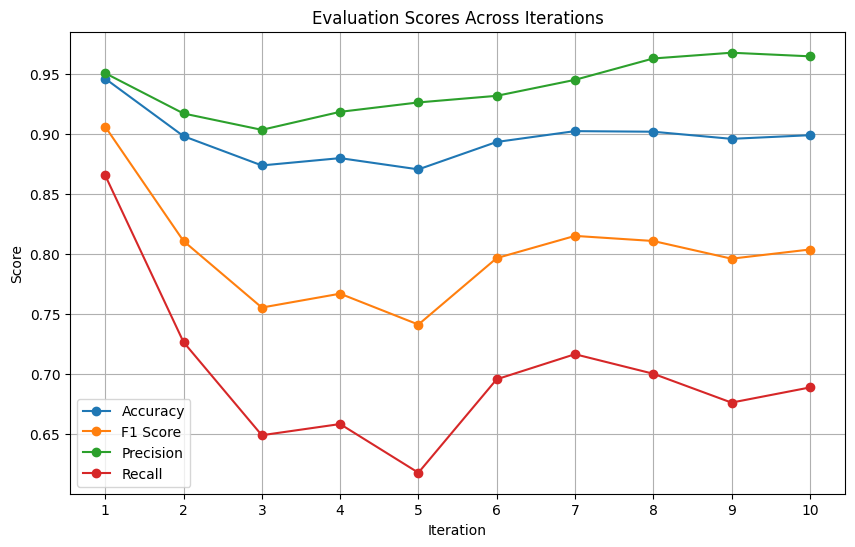


Final Evaluation Scores:
Iteration 1 - Accuracy: 0.9462, F1 Score: 0.9062, Precision: 0.9508, Recall: 0.8656
Iteration 2 - Accuracy: 0.8983, F1 Score: 0.8110, Precision: 0.9172, Recall: 0.7267
Iteration 3 - Accuracy: 0.8740, F1 Score: 0.7555, Precision: 0.9036, Recall: 0.6492
Iteration 4 - Accuracy: 0.8800, F1 Score: 0.7671, Precision: 0.9186, Recall: 0.6585
Iteration 5 - Accuracy: 0.8707, F1 Score: 0.7414, Precision: 0.9264, Recall: 0.6179
Iteration 6 - Accuracy: 0.8935, F1 Score: 0.7967, Precision: 0.9320, Recall: 0.6958
Iteration 7 - Accuracy: 0.9025, F1 Score: 0.8153, Precision: 0.9453, Recall: 0.7167
Iteration 8 - Accuracy: 0.9020, F1 Score: 0.8110, Precision: 0.9631, Recall: 0.7004
Iteration 9 - Accuracy: 0.8961, F1 Score: 0.7963, Precision: 0.9679, Recall: 0.6764
Iteration 10 - Accuracy: 0.8991, F1 Score: 0.8039, Precision: 0.9649, Recall: 0.6890


In [ ]:
#print(f"Initial Number of Nodes: {cora_data.num_nodes}")
#node_embeddings_final, removed_nodes=iterative_anomaly_detection(load_cora_from_drive(),node_embeddings, 10)
node_embeddings_final, removed_nodes=iterative_anomaly_detection(load_pubmed_from_drive(),node_embeddings, 10)
